In [1]:
# Importul bibliotecilor
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Citire fișiere
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
# Prelucrarea datelor din train_df
# Se lucrează doar pe train_df (setul de antrenament)
data = train_df.copy()

# Eliminare coloane irelevante
data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Completare valori lipsă
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

# One-Hot Encoding pentru variabile categorice
data = pd.get_dummies(data, columns=['Sex', 'Embarked'], drop_first=True)

# Separare în X și y
X = data.drop('Survived', axis=1)
y = data['Survived']

# Separare în variabile independente (X) și țintă (y)
X = data.drop('Survived', axis=1)
y = data['Survived']

<ipython-input-3-56329df6d7a1>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)
<ipython-input-3-56329df6d7a1>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [4]:
# Standardizare
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Aplicare SMOTE pentru balansarea claselor
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

In [6]:
# Selecție de trăsături cu RFE
estimator = RandomForestClassifier(random_state=42)
selector = RFE(estimator, n_features_to_select=6)
X_selected = selector.fit_transform(X_resampled, y_resampled)

In [7]:
# Tuning hiperparametri cu GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid.fit(X_selected, y_resampled)

best_model = grid.best_estimator_

In [8]:
# Validare încrucișată cu 10 fold CV
scores = cross_val_score(best_model, X_selected, y_resampled, cv=10, scoring='accuracy')
print(f"Acuratețea medie (10-fold CV): {np.mean(scores) * 100:.2f}%")

Acuratețea medie (10-fold CV): 83.52%


In [11]:
# Evaluare finală pe set de test (train/test split din datele resample-uite)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_resampled, test_size=0.2, random_state=42)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       103
           1       0.88      0.85      0.87       117

    accuracy                           0.86       220
   macro avg       0.86      0.86      0.86       220
weighted avg       0.86      0.86      0.86       220



Matricea de confuzie:


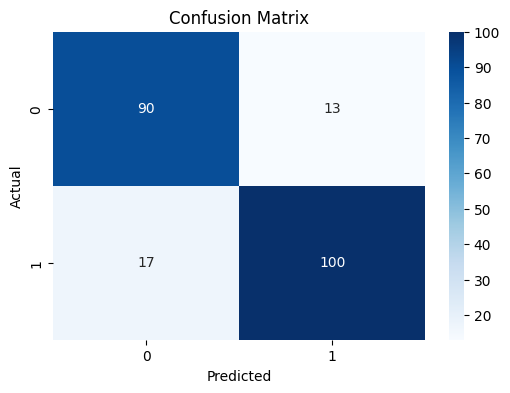

In [14]:
# Matricea de confuzie
print("Matricea de confuzie:")
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()